# Лабораторная работа №3

Бирюков В. В.

Группа: М8О-407Б-19

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, LabelBinarizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import max_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin, clone
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression as skLogisticRegression

In [3]:
from joblib import Parallel, delayed

# Регрессия

In [3]:
def scores_regr(model, data, target):
    pred = model.predict(data)
    print("Max error:", max_error(target, pred))
    print("MAE:", mean_absolute_error(target, pred))
    print("MSE:", mean_squared_error(target, pred))
    print("R^2:", r2_score(target, pred))
    fig = plt.figure(figsize=(6, 6))
    fig.add_subplot(111, aspect='equal')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.axline((0, 0), (1, 1), ls='--', c='grey')
    plt.scatter(target, pred, marker='o')
    plt.show()

## Дерево решений

In [12]:
class DecisionTree(BaseEstimator, RegressorMixin):
    class Node:
        def __init__(self):
            self.feature = -1
            self.value = None
            self.left = None
            self.right = None
    
    def __init__(self, min_leaf_size=5, max_depth=None, criterion='mse', answer='mean', features=None):
        self.min_leaf_size = min_leaf_size
        self.max_depth = max_depth
        self.criterion = criterion
        self.answer = answer
        self.features = features
    
    def fit(self, data, target):
        self.root = self.Node()
        self.process_node(data, target, self.root, np.arange(len(target)), 0)
        return self
    
    def crit(self, y_sum, y_sq_sum, y_med_sum, n):
        if self.criterion == 'mse':
            return y_sq_sum / n - y_sum ** 2 / n ** 2
        elif self.criterion == 'mae':
            return y_med_sum / n 
        elif self.criterion == 'poisson':
            return -y_sum / n * np.log(y_sum / n)
        
    def process_node(self, data, target, node, ids, depth):
        X = data[ids]
        Y = target[ids]
        n = len(X)
        y_sum = np.sum(Y)
        y_sq_sum = np.sum(Y ** 2)
        y_med = np.median(Y)
        y_med_sum = np.sum(np.abs(Y - y_med))
        
        if (self.max_depth is not None) and depth == self.max_depth or \
           (self.min_leaf_size is not None) and n <= self.min_leaf_size:
            if self.answer == 'mean':
                node.value = y_sum / n
            elif self.answer == 'median':
                node.value = y_med
            return
        
        h = self.crit(y_sum, y_sq_sum, y_med_sum, n)
        max_value = None
        max_f = None
        max_gain = -1
        best_left_ids = None
        best_right_ids = None
        for f in (self.features if self.features is not None else range(data.shape[1])):
            sort_ids = X[:, f].argsort()
            left = 1
            left_sum = Y[sort_ids[0]]
            left_sq_sum = Y[sort_ids[0]] ** 2
            left_med_sum = np.abs(Y[sort_ids[0]] - y_med)

            while left < n:
                while left < n and X[sort_ids[left-1]][f] == X[sort_ids[left-2]][f]:
                    left += 1
                    left_sum += Y[sort_ids[left-1]]
                    left_sq_sum += Y[sort_ids[left-1]] ** 2
                    left_med_sum += np.abs(Y[sort_ids[left-1]] - y_med)
                if left == n:
                    break
                    
                left_h = self.crit(left_sum, left_sq_sum, left_med_sum, left)
                right_h = self.crit(y_sum - left_sum, y_sq_sum - left_sq_sum, y_med_sum - left_med_sum, n - left)

                gain = h - (left * left_h + (n - left) * right_h) / n
                if gain > max_gain:
                    max_gain = gain
                    max_value = X[sort_ids[left-1]][f]
                    max_f = f
                    best_left_ids = sort_ids[:left]
                    best_right_ids = sort_ids[left:]

                left += 1
                left_sum += Y[sort_ids[left-1]]
                left_sq_sum += Y[sort_ids[left-1]] ** 2
                left_med_sum += np.abs(Y[sort_ids[left-1]] - y_med)
        
        if max_value is None:
            if self.answer == 'mean':
                node.value = y_sum / n
            elif self.answer == 'median':
                node.value = y_med
            return
        
        node.feature = max_f
        node.value = max_value
        node.left = self.Node()
        node.right = self.Node()
        
        self.process_node(X, Y, node.left, best_left_ids, depth+1)
        self.process_node(X, Y, node.right, best_right_ids, depth+1)
        
    def predict(self, data):
        res = np.ndarray(data.shape[0])
        for i, obj in enumerate(data):
            node = self.root
            while node.feature != -1:
                if obj[node.feature] > node.value:
                    node = node.right
                else:
                    node = node.left
            res[i] = node.value
        return res

## Случайный лес

In [5]:
class RandomForest(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, min_leaf_size=5, max_depth=None, criterion='mse', max_features='sqrt', answer='mean', max_samples=0.8):
        self.n_estimators = n_estimators
        self.min_leaf_size = min_leaf_size
        self.max_depth = max_depth
        self.answer = answer
        self.criterion = criterion
        self.max_features = max_features
        self.max_samples = max_samples
        
    def fit(self, data, target):
        features = np.arange(data.shape[1])
        indexes = np.arange(len(data))
        samples = int(np.floor(self.max_samples * len(data)))
        if self.max_features == 'sqrt':
            max_features = int(np.floor(np.sqrt(len(features))))
        else:
            max_features = int(np.floor(len(features) * self.max_features))
        self.estimators = []
        for _ in range(self.n_estimators):
            np.random.shuffle(features)
            self.estimators.append(DecisionTree(min_leaf_size=self.min_leaf_size, max_depth=self.max_depth, criterion=self.criterion, answer=self.answer, features=features[:max_features]))
            idx = np.random.choice(indexes, (samples, ))
            self.estimators[-1].fit(data[idx], target[idx])
        
    def predict(self, data):
        pred = np.stack([est.predict(data) for est in self.estimators], axis=1)
        if self.answer == 'mean':
            return pred.mean(axis=1)
        elif self.answer == 'median':
            return np.median(pred, axis=1)

## Датасет [Concrete Compressive Strength](https://www.kaggle.com/datasets/niteshyadav3103/concrete-compressive-strength)

In [6]:
data1 = pd.read_csv('../data/Concrete Compressive Strength.csv')
data1.columns=['Cement','Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
              'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength']

In [7]:
x = data1.drop(columns = 'Strength').to_numpy()
y = data1['Strength'].to_numpy()
train_data1, test_data1, train_target1, test_target1 = train_test_split(x, y, train_size=0.8, random_state=1)

## Предсказания

Одиночное дерево

In [18]:
dt_cv = GridSearchCV(Pipeline([('scaler', Normalizer()), ('tree', DecisionTree())]), 
                     {'tree__criterion': ['mse', 'poisson'], 'tree__max_depth': [10, 20, None], 
                      'tree__min_leaf_size': [1, 5, 10], 'tree__answer': ['mean', 'median']})
dt_cv.fit(train_data1, train_target1)
print(dt_cv.best_params_, dt_cv.best_score_, sep='\n')

{'tree__answer': 'mean', 'tree__criterion': 'mse', 'tree__max_depth': 20, 'tree__min_leaf_size': 5}
0.7521049683849069


Max error: 41.984262068
MAE: 5.772610978436216
MSE: 73.80822161902006
R^2: 0.7168804103896775


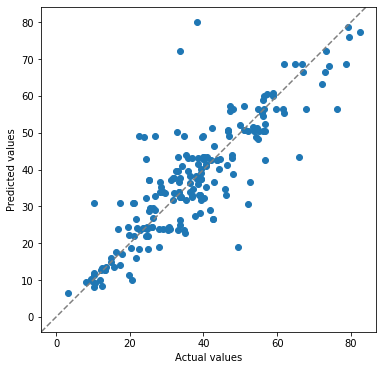

In [19]:
dt = dt_cv.best_estimator_
scores_regr(dt, test_data1, test_target1)

Дерево решений

In [24]:
rf_cv = GridSearchCV(Pipeline([('scaler', Normalizer()), ('rf', RandomForest(answer='mean', max_features=5))]),
                     {'rf__max_samples': [0.8, 1], 'rf__n_estimators': [30, 50], 
                      'rf__min_leaf_size': [1, 5], 'rf__criterion': ['mse', 'poisson']})
rf_cv.fit(train_data1, train_target1)
print(rf_cv.best_params_, rf_cv.best_score_, sep='\n')

{'rf__criterion': 'mse', 'rf__max_samples': 1, 'rf__min_leaf_size': 1, 'rf__n_estimators': 50}
0.8783832190200404


Max error: 26.378843517455035
MAE: 4.106682957935055
MSE: 35.14880399973595
R^2: 0.8651733540598614


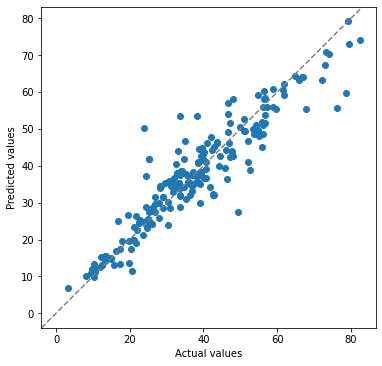

In [25]:
rf = rf_cv.best_estimator_
scores_regr(rf, test_data1, test_target1)

Сравним с самой лучшей моделью из предыдущей лабораторной

Max error: 23.26133444520001
MAE: 3.574541617362997
MSE: 27.69138478387754
R^2: 0.8937791302407887


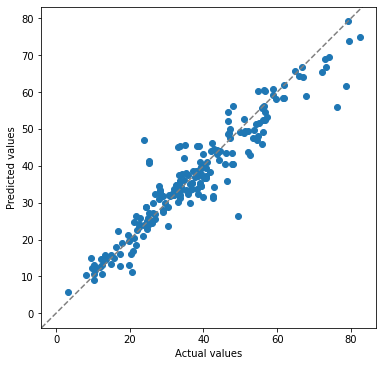

In [27]:
rf_cv = RandomForestRegressor(criterion='absolute_error', max_depth=100, min_samples_leaf=1, n_estimators=50)
rf_cv.fit(train_data1, train_target1)
scores_regr(rf_cv, test_data1, test_target1)

Превзойти не получилось, но результаты довольно близкие

# Классификация

In [4]:
def scores_class(model, data, labels):
    binary = (len(np.unique(labels)) == 2)
    pred = model.predict(data)
    print('Accuracy:', accuracy_score(labels, pred))
    if binary:
        print('Precision:', precision_score(labels, pred))
        print('Recall:', recall_score(labels, pred))
    figure = plt.figure(figsize=(12, 4))
    matrix = confusion_matrix(labels, pred)
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(matrix).plot(ax=ax)
    if binary:
        ax = plt.subplot(1, 2, 2)
        RocCurveDisplay.from_predictions(labels, pred, ax=ax)
    plt.subplots_adjust(wspace=0.3)
    plt.show()

## Логистическая регрессия

In [5]:
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.1, batch=10, epochs=1, alpha=0.0001):
        self.lr = lr
        self.batch = batch
        self.epochs = epochs
        self.alpha = alpha
    
    def fit(self, data, labels):
        self.w = np.random.normal(0, 1, (data.shape[1]+1,))
        data = np.concatenate((data, np.ones((data.shape[0],1))), axis=1)
        for _ in range(self.epochs):
            for i in range(self.batch, len(data), self.batch):
                data_batch = data[i-self.batch:i]
                labels_batch = labels[i-self.batch:i]
                
                pred = self.sigmoid(np.dot(self.w, data_batch.T))
                grad = 2 * self.alpha * self.w + np.dot(pred - labels_batch, data_batch)
                
                self.w -= self.lr * grad
        return self
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def predict(self, data):
        return (self.sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w)) > 0.5).astype('int64')
    
    def predict_proba(self, data):
        return self.sigmoid(np.concatenate((data, np.ones((data.shape[0],1))), axis=1).dot(self.w))

In [6]:
class OneVsRestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator, n_jobs=None):
        self.estimator = estimator
        self.n_jobs = n_jobs
    
    def fit(self, data, labels):
        label_binarizer = LabelBinarizer()
        Y = label_binarizer.fit_transform(labels)
        self.classes = label_binarizer.classes_
        columns = (col.ravel() for col in Y.T)
        self.estimators = Parallel(n_jobs=self.n_jobs)(delayed(clone(self.estimator).fit)(data, column) for column in columns)
    
    def predict_proba(self, data):
        pred = np.array([est.predict_proba(data) for est in self.estimators]).T
        return pred / pred.sum(axis=1)[:, np.newaxis]
    
    def predict(self, data):
        pred = np.array([est.predict_proba(data) for est in self.estimators]).T
        return pred.argmax(axis=1)
    
    def set_params(self, **kwargs):
        self.estimator.set_params(**kwargs)

In [7]:
def smote(data, labels):
    rng = np.random.default_rng()
    classes, counts = np.unique(labels, return_counts=True)
    sort_idx = counts.argsort()
    classes = classes[sort_idx]
    counts = counts[sort_idx]
    max_count = counts[-1]
        
    new_data = []
    new_labels = []
    for label, count in zip(classes[:-1], counts[:-1]):
        cur_class = data[labels == label]
        for i in range(max_count - count):
            obj1, obj2 = rng.choice(cur_class, 2, replace=False)
            new_obj = obj1 + (obj2 - obj1) * rng.random(1)
            new_data.append(new_obj)
            new_labels.append(label)
            
    return np.concatenate([data, new_data]), np.concatenate([labels, new_labels])

## Датасет [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17)

In [8]:
data2 = pd.read_csv('../data/star_classification.csv')

In [9]:
data2.head(10)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
5,1.237680e+18,340.995121,20.589476,23.48827,23.33776,21.32195,20.25615,19.54544,8102,301,3,110,5.658977e+18,QSO,1.424659,5026,55855,741
6,1.237679e+18,23.234926,11.418188,21.46973,21.17624,20.92829,20.60826,20.42573,7773,301,2,462,1.246262e+19,QSO,0.586455,11069,58456,113
7,1.237679e+18,5.433176,12.065186,22.24979,22.02172,20.34126,19.48794,18.84999,7773,301,2,346,6.961443e+18,GALAXY,0.477009,6183,56210,15
8,1.237661e+18,200.290475,47.199402,24.40286,22.35669,20.61032,19.46490,18.95852,3716,301,5,108,7.459285e+18,GALAXY,0.660012,6625,56386,719
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,18.81823,18.65422,5934,301,4,122,2.751763e+18,STAR,-0.000008,2444,54082,232


In [10]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

Пропусков в данных не наблюдается. Закодируем целевую переменную

In [11]:
data2['class'] = data2['class'].replace({'GALAXY': 0, 'STAR': 1, 'QSO': 2})

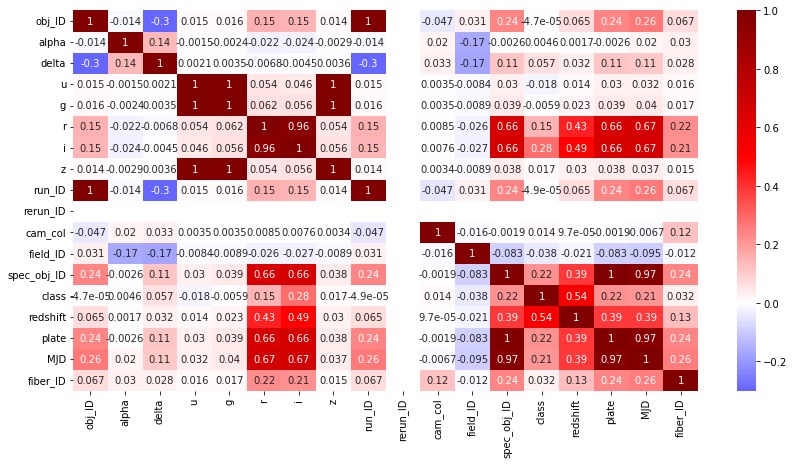

In [12]:
plt.figure(figsize=(14, 7))
sns.heatmap(data2.corr(), annot=True, center=0, cmap='seismic')
pass

Присутствуют скоррелированные между собой признаки: u, g и z; r и i. Оставим из каждой группы признак с наибольшей корреляцией с целевой переменной. Также уберем из данных все идентификаторы, так как если они и коррелируют с целевой переменной, корреляция скорее всего ложная

In [13]:
data2 = data2.drop(columns=['field_ID', 'run_ID', 'obj_ID', 'fiber_ID', 'spec_obj_ID', 'rerun_ID', 'plate', 'MJD', 'g', 'r', 'z'])

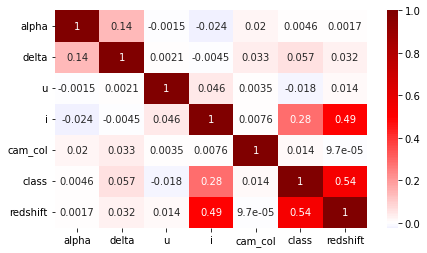

In [14]:
plt.figure(figsize=(7, 4))
sns.heatmap(data2.corr(), annot=True, center=0, cmap='seismic')
pass

In [15]:
data2.describe()

,alpha,delta,u,i,cam_col,class,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,19.084854,3.511610,0.595160,0.576661
std,96.502241,19.644665,31.769291,1.757895,1.586912,0.787509,0.730707
min,0.005528,-18.785328,-9999.000000,9.469903,1.000000,0.000000,-0.009971
25%,127.518222,5.146771,20.352353,17.732285,2.000000,0.000000,0.054517
50%,180.900700,23.645922,22.179135,19.405145,4.000000,0.000000,0.424173
75%,233.895005,39.901550,23.687440,20.396495,5.000000,1.000000,0.704154
max,359.999810,83.000519,32.781390,32.141470,6.000000,2.000000,7.011245


У столбца u очень странный минимум, не соответствующий среднему и дисперсии

In [16]:
data2[data2['u'] < 0]

,alpha,delta,u,i,cam_col,class,redshift
79543,224.006526,-0.624304,-9999.0,18.01675,2,1,0.000089


Действительно, присутствует один объект с выбросом в признаке u, заменим его значение на среднее этого признака в данном классе

In [17]:
data2.iat[79543, 2] = data2[data2['class'] == 1]['u'].mean()

Распределения признаков. Больше выбросов не наблюдается

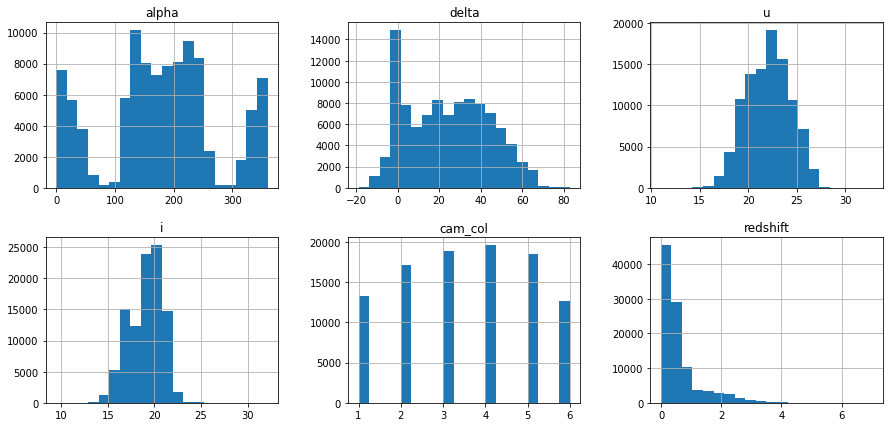

In [18]:
data2.hist(['alpha', 'delta', 'u', 'i', 'cam_col', 'redshift'], layout=(2, 3), figsize=(15, 7), bins=20)
pass

Попарные распределения признаков. Видно, что данные довольно плохо разделимы линейно, разделимость наблюдается только по признаку redshift

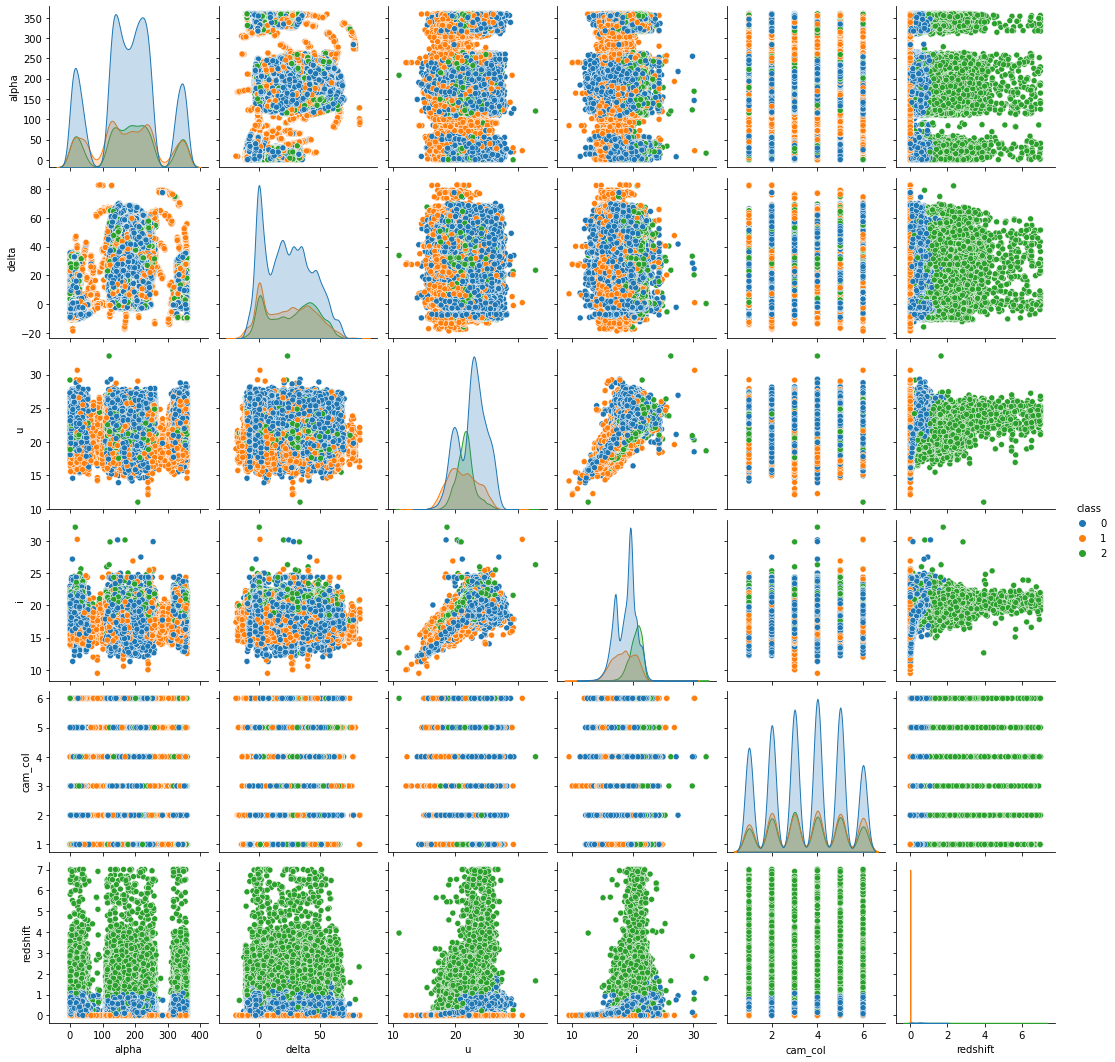

In [ ]:
sns.pairplot(data=data2, hue='class', palette='tab10')
pass

Соотношения классов

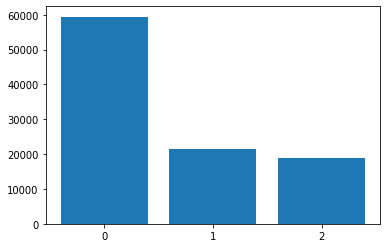

In [19]:
indexes = data2['class'].value_counts().index
counts = data2['class'].value_counts().values
plt.xticks(indexes)

plt.bar(indexes, counts)
plt.show()

Классы очень сильно несбалансированы. Применим алгоритм оверсэпмлинга SMOTE.

In [20]:
x = data2.drop(columns = 'class').to_numpy()
y = data2['class'].to_numpy()
x, y = smote(x, y)
train_data2, test_data2, train_labels2, test_labels2 = train_test_split(x, y, train_size=0.8, random_state=1)

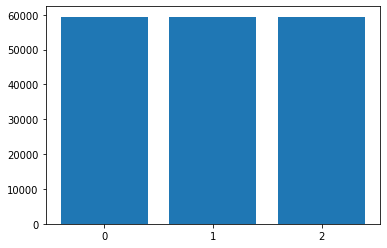

In [21]:
indexes, counts = np.unique(y, return_counts=True)
plt.xticks(indexes)

plt.bar(indexes, counts)
plt.show()

## Предсказания

Данные содержат три класса, поэтому единственной моделью не обойтись. Используем стратегию one vs rest.

In [22]:
log_cv = RandomizedSearchCV(Pipeline([('scaler', StandardScaler()), ('log', OneVsRestClassifier(LogisticRegression(), n_jobs=3))]),
                            {'log__lr': [0.01, 0.001], 'log__epochs': [10, 100, 1000], 
                             'log__batch': [10, 100, 1000]})
log_cv.fit(train_data2, train_labels2)
print(log_cv.best_params_, log_cv.best_score_, sep='\n')

{'log__lr': 0.001, 'log__epochs': 1000, 'log__batch': 1000}
0.9464350645049988


Accuracy: 0.9463930243642583


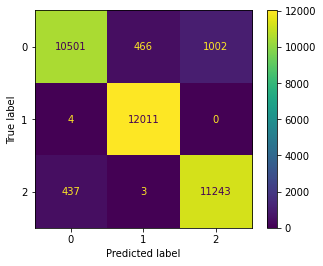

In [23]:
log = log_cv.best_estimator_
scores_class(log, test_data2, test_labels2)

Сравним с готовым классификатором

In [25]:
sk_log_cv = GridSearchCV(Pipeline([('scaler', StandardScaler()), ('log', skLogisticRegression())]),
                         {'log__max_iter': [100, 1000, 5000], 'log__C': [1, 0.9, 0.5]})
sk_log_cv.fit(train_data2, train_labels2)
print(sk_log_cv.best_params_, sk_log_cv.best_score_, sep='\n')

{'log__C': 1, 'log__max_iter': 100}
0.9557153499865534


Accuracy: 0.956318165250792


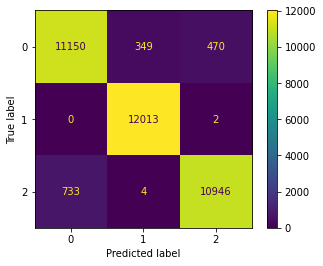

In [26]:
sk_log = sk_log_cv.best_estimator_
scores_class(sk_log, test_data2, test_labels2)

Результаты снова довольно близки